<!-- <img src="UNET-architecture.jpg" alt="Title" style="width: 500px;"/> -->
<div style="text-align: center;">
    <img src="model.png" alt="Title" style="width: 500px;"/>
</div>

#### Import

In [12]:
import os
import time
import numpy as np
import cv2            
from glob import glob 
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

#### Seeding (helps in reproducibility)

In [24]:
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

#### Hyperparameters

In [13]:
batch_size = 4
lr = 1e-4
epochs = 25
height = 1100
width = 1344

#### Path for datasets

In [44]:
dataset_path = './dataset'

#### Path for saving model and training logs

In [45]:
files_dir = os.path.join(os.getcwd(), "files")
model_file = os.path.join(files_dir, "unet.h5")
log_file = os.path.join(files_dir, "log.csv")

#### Creating Files directory to save model and training logs

In [14]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [29]:
create_dir(files_dir)

#### Building UNET

##### Conv Block

In [30]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation ("relu")(x)
    
    return x

##### Encoder Block

In [31]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

##### Decoder Block

In [32]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding = "same")(inputs)
        
    # Compute the difference in shape
    h_diff = skip.shape[1] - x.shape[1]
    w_diff = skip.shape[2] - x.shape[2]

    # Pad the smaller tensor to match the larger one
    if h_diff > 0:
        x = ZeroPadding2D(padding=((0, h_diff), (0, 0)))(x)
    elif h_diff < 0:
        skip = ZeroPadding2D(padding=((0, -h_diff), (0, 0)))(skip)

    if w_diff > 0:
        x = ZeroPadding2D(padding=((0, 0), (0, w_diff)))(x)
    elif w_diff < 0:
        skip = ZeroPadding2D(padding=((0, 0), (0, -w_diff)))(skip)

    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

##### UNET

In [33]:
def build_unet(input_shape):
    inputs = Input(input_shape)
    
    ''' Encoder '''
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    ''' Bottleneck '''
    b1 = conv_block(p4, 1024)
    
    ''' Decoder '''
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    ''' Output '''
    outputs = Conv2D(1, 1, padding = "same", activation = "sigmoid")(d4)

    model = Model(inputs, outputs, name = "UNET")
    return model


#### Dataset Pipeline

##### Loading the training and validation dataset

In [46]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "masks", "*")))
    
    valid_x = sorted(glob(os.path.join(path, "valid", "images", "*")))
    valid_y = sorted(glob(os.path.join(path, "valid", "masks", "*")))
    
    
    return (train_x, train_y), (valid_x, valid_y)

##### Reading Images

In [15]:
target_height = 1100
target_width = 1344

In [36]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (target_width, target_height), interpolation=cv2.INTER_AREA)
    x = x/255.0
    return x

##### Reading Masks

In [37]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (target_width, target_height), interpolation=cv2.INTER_AREA)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

##### tf.data pipeline

In [38]:
def tf_parse(x,y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    
    return x, y

In [39]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

#### Training

In [47]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 200 - 200
Valid: 12 - 12


In [48]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

2024-07-26 16:32:01.257466: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 16:32:01.961836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [51]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [53]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1100, 1344,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 1100, 1344,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 1100, 1344,   256        ['conv2d_19[0][0]']              
 ormalization)                  64)                                                            

In [54]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])

In [55]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [ ]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/25


2024-07-26 16:32:43.435443: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


50/50 [==============================] - ETA: 0s - loss: 0.7186 - acc: 0.6147
Epoch 00001: val_loss improved from inf to 0.71036, saving model to /blue/pinaki.sarder/iansari/images/model/H-E/files/new-images-aug-25-epochs-batch4-all/unet-aug.h5
50/50 [==============================] - 92s 1s/step - loss: 0.7186 - acc: 0.6147 - val_loss: 0.7104 - val_acc: 0.3913 - lr: 1.0000e-04
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 0.5695 - acc: 0.7370
Epoch 00002: val_loss improved from 0.71036 to 0.63688, saving model to /blue/pinaki.sarder/iansari/images/model/H-E/files/new-images-aug-25-epochs-batch4-all/unet-aug.h5
50/50 [==============================] - 109s 2s/step - loss: 0.5695 - acc: 0.7370 - val_loss: 0.6369 - val_acc: 0.7010 - lr: 1.0000e-04
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 0.5193 - acc: 0.7580
Epoch 00003: val_loss did not improve from 0.63688
50/50 [==============================] - 147s 3s/step - loss: 0.5193 - acc: 0.7580

### Testing the model

#### creating folder to save the predictions and model

In [16]:
test_dataset_path = './dataset/test'
save_path = "./predictions"
model_path = "files/unet.h5"

In [17]:
create_dir(save_path)

In [9]:
model = tf.keras.models.load_model(model_path)

2024-07-27 01:18:58.326802: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 01:18:59.253753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


#### loading the test images

In [18]:
test_x = glob(os.path.join(test_dataset_path, "images", "*"))
print(f"Test Images: {len(test_x)}")

Test Images: 12


#### predicting and saving

In [17]:
time_taken = []
for x in tqdm(test_x):
    name = x.split("/")[-1].split(".")[0]  # Use os.path.split to get the filename
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (target_width, target_height), interpolation=cv2.INTER_AREA)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    
    start_time = time.time()
    p = model.predict(x)[0]
    total_time = time.time() - start_time
    time_taken.append(total_time)
   
    p = p * 255 
    
    p = p.astype(np.uint8)

    cv2.imwrite(os.path.join(save_path, name), p)



100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


### Metrics

#### Creating directory to save metrics

In [ ]:
metrics_path = "./metrics"
manual_metric_path = os.path.join(metrics_path, "manual")
li_metric_path = os.path.join(metrics_path, "li")
youden_metric_path = os.path.join(metrics_path, "youden")
distance_metric_path = os.path.join(metrics_path, "distance")

In [ ]:
create_dir(metrics_path)
create_dir(manual_metric_path)
create_dir(li_metric_path)
create_dir(youden_metric_path)
create_dir(distance_metric_path)

#### Load predicted masks and ground truth mask

In [19]:
pred_mask = sorted(glob(os.path.join("predictions", "*")))
true_mask = sorted(glob(os.path.join(test_dataset_path, "masks", "*")))

### Function to calculate metrics

In [20]:
def calculate_metrics(true_y, pred_y):
    # Calculate true positives, false positives, true negatives, false negatives
    tp = np.sum((true_y == 1) & (pred_y == 1))
    tn = np.sum((true_y == 0) & (pred_y == 0))
    fp = np.sum((true_y == 0) & (pred_y == 1))
    fn = np.sum((true_y == 1) & (pred_y == 0))

    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Calculate Jaccard index (IoU)
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0

    return accuracy, precision, recall, f1, jaccard


#### Metrics for 0.5 thresholding

In [21]:
score = []

for pred_y_path, true_y_path in tqdm(zip(pred_mask, true_mask), total=len(pred_mask)):
    name = pred_y_path.split("/")[-1].split(".")[0]
    
    # Load predicted mask and preprocess
    pred_y = cv2.imread(pred_y_path, cv2.IMREAD_GRAYSCALE)
    pred_y = pred_y / 255.0
    pred_y = pred_y > 0.5
    pred_y = pred_y.astype(np.int32)
    # pred_y = pred_y.flatten()

    # Load true mask and preprocess
    true_y = cv2.imread(true_y_path, cv2.IMREAD_GRAYSCALE)
    true_y = cv2.resize(true_y, (1344, 1100))  # Corrected resizing using OpenCV
    true_y = true_y / 255.0
    true_y = true_y > 0.5
    true_y = true_y.astype(np.int32)
    # true_y = true_y.flatten()
    
    pred_y1 = (pred_y * 255).astype(np.uint8)
    save_path = f'./metrics/manual/0.5_{name}.png'  # Specify your save directory
    cv2.imwrite(save_path, pred_y1)
    

    # Calculate metrics manually
    accuracy, precision, recall, f1, jaccard = calculate_metrics(true_y, pred_y)

    # Append results to score list
    score.append([name, accuracy, f1, jaccard, recall, precision])


100%|██████████| 12/12 [00:00<00:00, 17.82it/s]


##### Display Metrics for each image

In [22]:
import pandas as pd

score_df = pd.DataFrame(score, columns=["Name", "Accuracy", "F1 Score", "Jaccard Index", "Recall", "Precision"])
print(score_df)

score_df.to_csv("./metrics/0.5_score.csv", index=False)

        Name  Accuracy  F1 Score  Jaccard Index    Recall  Precision
0   15_0.TIF  0.981011  0.607543       0.436310  0.590762   0.625306
1   19_0.TIF  0.945170  0.388251       0.240888  0.385196   0.391355
2   25_0.TIF  0.952045  0.367076       0.224797  0.333967   0.407472
3   30_0.TIF  0.965121  0.242527       0.137997  0.168904   0.429926
4    3_0.TIF  0.958256  0.084768       0.044260  0.044648   0.835917
5   40_0.TIF  0.960983  0.052125       0.026760  0.029851   0.205334
6   52_0.TIF  0.956330  0.278317       0.161654  0.214457   0.396339
7   58_0.TIF  0.954264  0.536762       0.366832  0.526023   0.547949
8   60_0.TIF  0.962662  0.055571       0.028579  0.029186   0.579173
9   63_0.TIF  0.960085  0.524638       0.355599  0.543123   0.507370
10   6_0.TIF  0.971784  0.136425       0.073206  0.080920   0.434353
11  71_0.TIF  0.967417  0.000000       0.000000  0.000000   0.000000


##### Calculate Mean Scores

In [23]:
score = [s[1:] for s in score if not (s[0] ==0 or s[1] ==0 or s[2] ==0 or s[3] ==0 or s[4] ==0)]

print(len(score))


mean_score = np.mean(score, axis=0)  # Assuming score is a numpy array

print(f"Accuracy: {mean_score[0]:0.5f}")
print(f"F1 score: {mean_score[1]:0.5f}")
print(f"Jaccard: {mean_score[2]:0.5f}")
print(f"Recall: {mean_score[3]:0.5f}")
print(f"Precision: {mean_score[4]:0.5f}")

11
Accuracy: 0.96070
F1 score: 0.29764
Jaccard: 0.19063
Recall: 0.26791
Precision: 0.48732


#### li thresholding

In [24]:
from skimage import filters

li_score = []

for pred_y_path, true_y_path in tqdm(zip(pred_mask, true_mask), total=len(pred_mask)):
    name = pred_y_path.split("/")[-1].split(".")[0]
    
    # Load predicted mask and preprocess
    pred_y = cv2.imread(pred_y_path, cv2.IMREAD_GRAYSCALE)
    pred_y = pred_y / 255.0

    # Apply Li thresholding
    threshold_value = filters.threshold_li(pred_y)
    pred_y = pred_y > threshold_value
    pred_y = pred_y.astype(np.int32)

    # Load true mask and preprocess
    true_y = cv2.imread(true_y_path, cv2.IMREAD_GRAYSCALE)
    true_y = cv2.resize(true_y, (1344, 1100))  # Corrected resizing using OpenCV
    true_y = true_y / 255.0
    true_y = true_y > 0.5
    true_y = true_y.astype(np.int32)
    
    pred_y1 = (pred_y * 255).astype(np.uint8)
    save_path = f'./metrics/li/li_{name}.png'  # Specify your save directory
    cv2.imwrite(save_path, pred_y1)

    # Calculate metrics manually
    accuracy, precision, recall, f1, jaccard = calculate_metrics(true_y, pred_y)

    # Append results to score list
    li_score.append([name, accuracy, f1, jaccard, recall, precision])

100%|██████████| 12/12 [00:01<00:00,  7.96it/s]


In [25]:
import pandas as pd

li_score_df = pd.DataFrame(li_score, columns=["Name", "Accuracy", "F1 Score", "Jaccard Index", "Recall", "Precision"])
print(li_score_df)

li_score_df.to_csv("./metrics/li_score.csv", index=False)

        Name  Accuracy  F1 Score  Jaccard Index    Recall  Precision
0   15_0.TIF  0.905507  0.343652       0.207476  0.994264   0.207725
1   19_0.TIF  0.817649  0.325670       0.194508  0.974842   0.195489
2   25_0.TIF  0.909683  0.392060       0.243827  0.699399   0.272371
3   30_0.TIF  0.953407  0.488517       0.323203  0.673057   0.383396
4    3_0.TIF  0.848367  0.291405       0.170552  0.720099   0.182662
5   40_0.TIF  0.868191  0.296202       0.173848  0.771805   0.183268
6   52_0.TIF  0.941803  0.416660       0.263152  0.529329   0.343537
7   58_0.TIF  0.908279  0.467655       0.305189  0.799777   0.330436
8   60_0.TIF  0.950298  0.257975       0.148089  0.229549   0.294438
9   63_0.TIF  0.919027  0.444391       0.285670  0.798472   0.307867
10   6_0.TIF  0.940085  0.323127       0.192696  0.519242   0.234542
11  71_0.TIF  0.756972  0.202668       0.112760  0.947935   0.113463


In [26]:
li_score = [s[1:] for s in li_score if not (s[0] ==0 or s[1] ==0 or s[2] ==0 or s[3] ==0 or s[4] ==0)]

print(len(li_score))


mean_score = np.mean(li_score, axis=0)  # Assuming score is a numpy array

print(f"Accuracy: {mean_score[0]:0.5f}")
print(f"F1 score: {mean_score[1]:0.5f}")
print(f"Jaccard: {mean_score[2]:0.5f}")
print(f"Recall: {mean_score[3]:0.5f}")
print(f"Precision: {mean_score[4]:0.5f}")

12
Accuracy: 0.89327
F1 score: 0.35417
Jaccard: 0.21841
Recall: 0.72148
Precision: 0.25410


#### Draws ROC Curve

In [27]:
def compute_roc_curve(true_y, pred_probabilities):
    thresholds = np.linspace(0, 1, 100)
    tprs = []
    fprs = []

    for threshold in thresholds:
        pred_y = pred_probabilities > threshold
        accuracy, precision, recall, f1, jaccard = calculate_metrics(true_y, pred_y)

        tp = np.sum((true_y == 1) & (pred_y == 1))
        tn = np.sum((true_y == 0) & (pred_y == 0))
        fp = np.sum((true_y == 0) & (pred_y == 1))
        fn = np.sum((true_y == 1) & (pred_y == 0))

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

        tprs.append(tpr)
        fprs.append(fpr)

    return fprs, tprs, thresholds


##### Find optimal threshold from ROC curve using Youden Index and Distance to (0,1) techniques

In [28]:
def find_optimal_threshold(fprs, tprs, thresholds, method='youden'):
    if method == 'youden':
        youden_index = np.array(tprs) - np.array(fprs)
        optimal_idx = np.argmax(youden_index)
    elif method == 'distance':
        distances = np.sqrt(np.array(fprs)**2 + (1 - np.array(tprs))**2)
        optimal_idx = np.argmin(distances)
    else:
        raise ValueError("Method not recognized. Use 'youden' or 'distance'.")

    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

#### Converting Pred to True Mask using two diffenet optimal threshold 

Youngs and Distance

Common methods to define the optimal threshold.

Youden's Index: Maximizes the difference between TPR and FPR (i.e., 
<div style="text-align: center;">
    <img src="youden.png" alt="Title" style="width: 500px;"/>
</div>

Distance to (0, 1): Minimizes the distance to the top-left corner of the ROC space (i.e.,

<div style="text-align: center;">
    <img src="distance.png" alt="Title" style="width: 500px;"/>
</div>


1. Call ROC and find_optimal functions to calculate matrices for each

2. Plot ROC curve for each to show where the optimal threshold lies

3. Saves the thresholded predictions 

  0%|          | 0/12 [00:00<?, ?it/s]

Optimal Threshold (Youden's Index): 0.15151515151515152
Optimal Threshold (Distance's Index): 0.17171717171717174


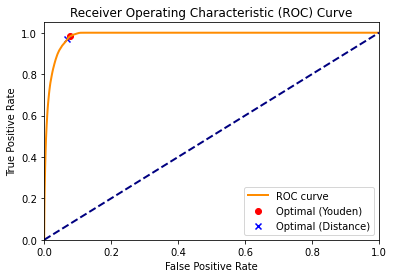

  8%|▊         | 1/12 [00:01<00:18,  1.65s/it]

Optimal Threshold (Youden's Index): 0.17171717171717174
Optimal Threshold (Distance's Index): 0.19191919191919193


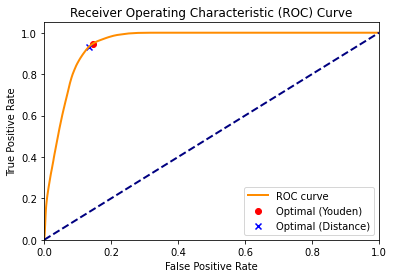

 17%|█▋        | 2/12 [00:03<00:16,  1.67s/it]

Optimal Threshold (Youden's Index): 0.030303030303030304
Optimal Threshold (Distance's Index): 0.04040404040404041


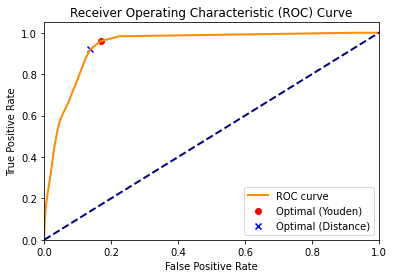

 25%|██▌       | 3/12 [00:05<00:15,  1.68s/it]

Optimal Threshold (Youden's Index): 0.030303030303030304
Optimal Threshold (Distance's Index): 0.030303030303030304


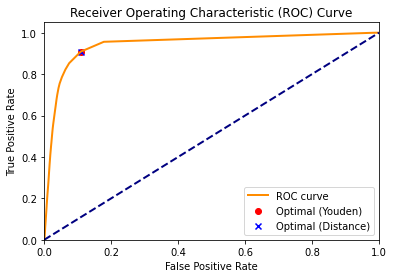

 33%|███▎      | 4/12 [00:06<00:13,  1.68s/it]

Optimal Threshold (Youden's Index): 0.04040404040404041
Optimal Threshold (Distance's Index): 0.05050505050505051


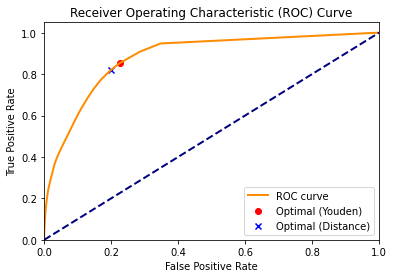

 42%|████▏     | 5/12 [00:08<00:11,  1.69s/it]

Optimal Threshold (Youden's Index): 0.030303030303030304
Optimal Threshold (Distance's Index): 0.04040404040404041


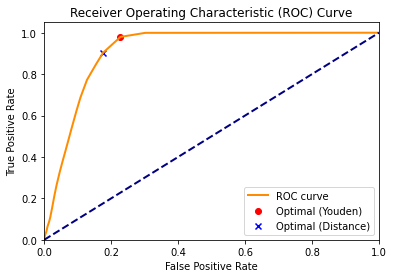

 50%|█████     | 6/12 [00:10<00:10,  1.73s/it]

Optimal Threshold (Youden's Index): 0.030303030303030304
Optimal Threshold (Distance's Index): 0.020202020202020204


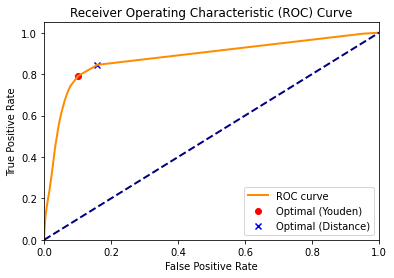

 58%|█████▊    | 7/12 [00:11<00:08,  1.71s/it]

Optimal Threshold (Youden's Index): 0.06060606060606061
Optimal Threshold (Distance's Index): 0.07070707070707072


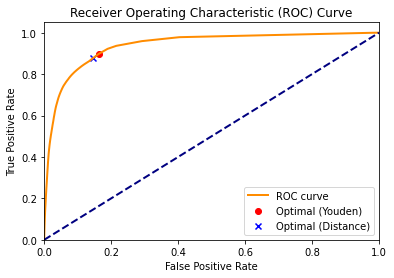

 67%|██████▋   | 8/12 [00:13<00:06,  1.71s/it]

Optimal Threshold (Youden's Index): 0.020202020202020204
Optimal Threshold (Distance's Index): 0.020202020202020204


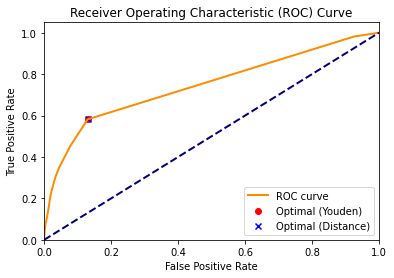

 75%|███████▌  | 9/12 [00:15<00:05,  1.72s/it]

Optimal Threshold (Youden's Index): 0.030303030303030304
Optimal Threshold (Distance's Index): 0.04040404040404041


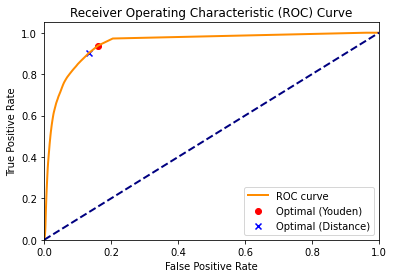

 83%|████████▎ | 10/12 [00:17<00:03,  1.72s/it]

Optimal Threshold (Youden's Index): 0.020202020202020204
Optimal Threshold (Distance's Index): 0.020202020202020204


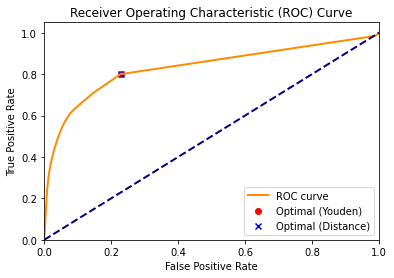

 92%|█████████▏| 11/12 [00:18<00:01,  1.71s/it]

Optimal Threshold (Youden's Index): 0.04040404040404041
Optimal Threshold (Distance's Index): 0.06060606060606061


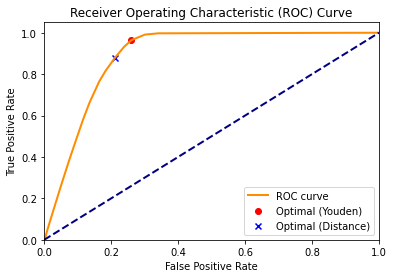

100%|██████████| 12/12 [00:20<00:00,  1.71s/it]


In [29]:
youden_score = []
distance_score = []
  # Fill with the paths to your true mask images

for pred_y_path, true_y_path in tqdm(zip(pred_mask, true_mask), total=len(pred_mask)):
    name = pred_y_path.split("/")[-1].split(".")[0]

    # Load predicted mask and preprocess
    pred_y = cv2.imread(pred_y_path, cv2.IMREAD_GRAYSCALE)
    pred_y = pred_y / 255.0  # Normalize to [0, 1]

    # Load true mask and preprocess
    true_y = cv2.imread(true_y_path, cv2.IMREAD_GRAYSCALE)
    true_y = cv2.resize(true_y, (1344, 1100))  # Corrected resizing using OpenCV
    true_y = true_y / 255.0  # Normalize to [0, 1]

    # Compute ROC curve
    fprs, tprs, thresholds = compute_roc_curve(true_y, pred_y)

    # Find optimal threshold
    youden_optimal_threshold = find_optimal_threshold(fprs, tprs, thresholds, method='youden')
    distance_optimal_threshold = find_optimal_threshold(fprs, tprs, thresholds, method='distance')
    
    print(f'Optimal Threshold (Youden\'s Index): {youden_optimal_threshold:.2f}')
    print(f'Optimal Threshold (Distance\'s Index): {distance_optimal_threshold:.2f}')

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fprs, tprs, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fprs[np.argmax(np.array(tprs) - np.array(fprs))], tprs[np.argmax(np.array(tprs) - np.array(fprs))], color='red', label='Optimal (Youden)', marker='o')
    plt.scatter(fprs[np.argmin(np.sqrt(np.array(fprs)**2 + (1 - np.array(tprs))**2))], tprs[np.argmin(np.sqrt(np.array(fprs)**2 + (1 - np.array(tprs))**2))], color='blue', label='Optimal (Distance)', marker='x')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Apply optimal threshold
    pred_y_binary_youden = pred_y > youden_optimal_threshold
    pred_y_binary_youden = pred_y_binary_youden.astype(np.int32)

    # Save the binary mask image
    binary_mask_uint8_youden = (pred_y_binary_youden * 255).astype(np.uint8)
    save_path_youden = f'./metrics/youden_{name}.png'  # Specify your save directory
    cv2.imwrite(save_path_youden, binary_mask_uint8_youden)
    
    # Apply optimal threshold
    pred_y_binary_distance = pred_y > distance_optimal_threshold
    pred_y_binary_distance = pred_y_binary_distance.astype(np.int32)

    # Save the binary mask image
    binary_mask_uint8_distance = (pred_y_binary_distance * 255).astype(np.uint8)
    save_path_distance = f'./metrics/distance_{name}.png'  # Specify your save directory
    cv2.imwrite(save_path_distance, binary_mask_uint8_distance)

    # Calculate metrics
    accuracy_youden, precision_youden, recall_youden, f1_youden, jaccard_youden = calculate_metrics(true_y, pred_y_binary_youden)
    accuracy_distance, precision_distance, recall_distance, f1_distance, jaccard_distance = calculate_metrics(true_y, pred_y_binary_distance)
    

    # Append results to score list
    youden_score.append([name, accuracy_youden, precision_youden, recall_youden, f1_youden, jaccard_youden])
    distance_score.append([name, accuracy_distance, precision_distance, recall_distance, f1_distance, jaccard_distance])    

In [30]:
import pandas as pd

youden_score_df = pd.DataFrame(youden_score, columns=["Name", "Accuracy", "F1 Score", "Jaccard Index", "Recall", "Precision"])

youden_score_df.to_csv("./metrics/youden_score.csv", index=False)

youden_score = [s[1:] for s in youden_score if not (s[0] ==0 or s[1] ==0 or s[2] ==0 or s[3] ==0 or s[4] ==0)]

mean_score = np.mean(youden_score, axis=0)  # Assuming score is a numpy array

print(f"Accuracy: {mean_score[0]:0.5f}")
print(f"F1 score: {mean_score[1]:0.5f}")
print(f"Jaccard: {mean_score[2]:0.5f}")
print(f"Recall: {mean_score[3]:0.5f}")
print(f"Precision: {mean_score[4]:0.5f}")

Accuracy: 0.83534
F1 score: 0.17757
Jaccard: 0.88358
Recall: 0.29235
Precision: 0.17333


In [31]:
import pandas as pd

distance_score_df = pd.DataFrame(distance_score, columns=["Name", "Accuracy", "F1 Score", "Jaccard Index", "Recall", "Precision"])

distance_score_df.to_csv("./metrics/distance_score.csv", index=False)

distance_score = [s[1:] for s in distance_score if not (s[0] ==0 or s[1] ==0 or s[2] ==0 or s[3] ==0 or s[4] ==0)]

mean_score = np.mean(distance_score, axis=0)  # Assuming score is a numpy array

print(f"Accuracy: {mean_score[0]:0.5f}")
print(f"F1 score: {mean_score[1]:0.5f}")
print(f"Jaccard: {mean_score[2]:0.5f}")
print(f"Recall: {mean_score[3]:0.5f}")
print(f"Precision: {mean_score[4]:0.5f}")

Accuracy: 0.84805
F1 score: 0.18424
Jaccard: 0.86098
Recall: 0.30104
Precision: 0.17943
